In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))
display(HTML("<style>.output_result { max-width:90% !important; }</style>"))

In [2]:
import sys
import os
sys.path.append(os.path.dirname(os.getcwd()))
import re
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
import pandas as pd
import cv2
import seaborn as sns
import pickle
import torch
from sklearn.metrics import auc

from matplotlib import rcParams
rcParams.update({'font.size': 16})

pd.options.display.float_format = '{:.4f}'.format

# rc('font', **{'family': 'serif', 'serif': ['Computer Modern'], 'size': 18})
# rc('text', usetex=True)

np.random.seed(42)

# Globals

In [113]:
# Load image and mask data
with open("/hdd0/projects/regex/evals/images_and_masks.pkl", 'rb') as f:
    images_and_masks = pickle.load(f)
methods = ["IoU (q=0.1)", "IoU (q=0.05)", "IoU (q=0.025)", "mAP"]
result_index = ["k", "method", "level", "metric", "value"]
mri_modality = 2

# Test random attributions

1367


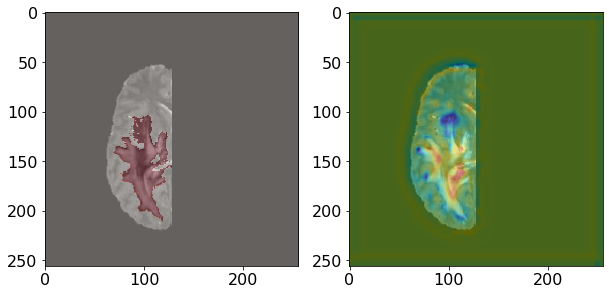

In [185]:
with open("/hdd0/projects/regex/evals/ensemble_attrs/k=3_marginal_attrs_level=3.pkl", 'rb') as f:
    attrs = pickle.load(f)
idx = np.random.randint(0, len(images_and_masks))
# idx = 455
print(idx)
fig, ax = plt.subplots(1, 2, figsize=(10,10))
image, label, mask = images_and_masks[idx]
ax[0].imshow(image[mri_modality], cmap="gray")
ax[0].imshow(mask, cmap="Reds", alpha=0.4)
ax[1].imshow(image[mri_modality], cmap="gray")
ax[1].imshow(cv2.resize(attrs[idx][0].numpy(), (256,256)), cmap="jet", alpha=0.4)

# Load data

In [133]:
result_dir = "/hdd0/projects/regex/evals/ensemble_results"
results = os.listdir(result_dir)
result_df = pd.DataFrame(columns=result_index)
for result in results:
    k, method, level, metric = re.search(r"k=([0-9]+)_method=([^\_]+)_lavel=([0-9]+)__(.+).pkl", result).groups()
    with open(os.path.join(result_dir, result), 'rb') as f:
        value = pickle.load(f)
        result_df = result_df.append({"k": k, "method": method, "level": level, "metric": metric, "value": value}, ignore_index=True)

In [164]:
t1 = result_df[result_df['level'] == '3'].groupby(["method", "metric"], as_index=False).mean().pivot(index=['metric'], columns=['method']) * 100
t1 = t1.applymap(lambda x: f"{x:.2f}")
t1

value                                               
method       DeepLIFT GradCAM InputXGradients    LRP Marginal    ViT
metric                                                              
map             47.80   56.76           36.65  36.65    63.58  56.19
qiou_q=0.025    34.02   31.96           25.67  25.67    39.09  29.60
qiou_q=0.05     27.79   37.75           22.43  22.43    42.17  36.72
qiou_q=0.1      18.01   30.71           15.40  15.40    30.31  33.61

In [165]:
t2 = result_df[result_df['level'] == '3'].groupby(["method", "metric"], as_index=False).std().pivot(index=['metric'], columns=['method']) * 100
t2 = t2.applymap(lambda x: f"{x:.2f}")
t2

value                                             
method       DeepLIFT GradCAM InputXGradients   LRP Marginal   ViT
metric                                                            
map              1.91   14.26            0.98  0.98     4.85  9.80
qiou_q=0.025     1.48    9.83            0.55  0.55     4.58  7.41
qiou_q=0.05      1.69    9.17            0.82  0.82     4.44  6.31
qiou_q=0.1       0.91    4.96            0.63  0.63     1.50  2.14

In [168]:
t1 + "+/-" + t2

value                                               \
method            DeepLIFT        GradCAM InputXGradients           LRP   
metric                                                                    
map           47.80+/-1.91  56.76+/-14.26    36.65+/-0.98  36.65+/-0.98   
qiou_q=0.025  34.02+/-1.48   31.96+/-9.83    25.67+/-0.55  25.67+/-0.55   
qiou_q=0.05   27.79+/-1.69   37.75+/-9.17    22.43+/-0.82  22.43+/-0.82   
qiou_q=0.1    18.01+/-0.91   30.71+/-4.96    15.40+/-0.63  15.40+/-0.63   

                                          
method            Marginal           ViT  
metric                                    
map           63.58+/-4.85  56.19+/-9.80  
qiou_q=0.025  39.09+/-4.58  29.60+/-7.41  
qiou_q=0.05   42.17+/-4.44  36.72+/-6.31  
qiou_q=0.1    30.31+/-1.50  33.61+/-2.14

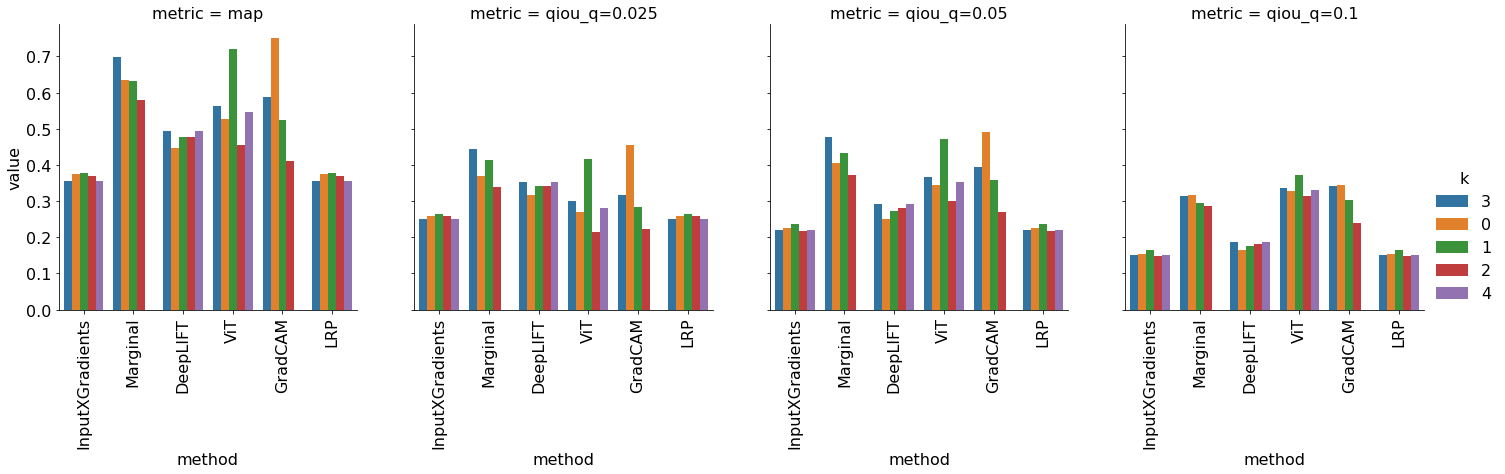

In [158]:
df3 = result_df[result_df['level'] == '3']
g = sns.catplot(x="method", y="value",
                hue="k", col="metric",
                data=df3, kind="bar")
g.set_xticklabels(rotation=90)

In [122]:
result_df.groupby(['method', "level", "metric"]).mean()

value
method          level metric             
DeepLIFT        3     map          0.4780
                      qiou_q=0.025 0.3402
                      qiou_q=0.05  0.2779
                      qiou_q=0.1   0.1801
                4     map          0.5403
                      qiou_q=0.025 0.3922
                      qiou_q=0.05  0.3211
                      qiou_q=0.1   0.2022
GradCAM         3     map          0.6370
                      qiou_q=0.025 0.3694
                      qiou_q=0.05  0.3723
                      qiou_q=0.1   0.2954
                4     map          0.6883
                      qiou_q=0.025 0.3855
                      qiou_q=0.05  0.4691
                      qiou_q=0.1   0.3657
InputXGradients 3     map          0.3665
                      qiou_q=0.025 0.2567
                      qiou_q=0.05  0.2243
                      qiou_q=0.1   0.1540
                4     map          0.3994
                      qiou_q=0.025 0.2770
                      qiou_q=0.05  0.2338
                      qiou_q=0.1   0.1601
LRP             3     map          0.3665
                      qiou_q=0.025 0.2567
                      qiou_q=0.05  0.2243
                      qiou_q=0.1   0.1540
                4     map          0.3994
                      qiou_q=0.025 0.2770
                      qiou_q=0.05  0.2338
                      qiou_q=0.1   0.1601
Marginal        3     map          0.6358
                      qiou_q=0.025 0.3909
                      qiou_q=0.05  0.4217
                      qiou_q=0.1   0.3031
                4     map          0.4577
                      qiou_q=0.025 0.2800
                      qiou_q=0.05  0.3100
                      qiou_q=0.1   0.2476
ViT             3     map          0.5619
                      qiou_q=0.025 0.2960
                      qiou_q=0.05  0.3672
                      qiou_q=0.1   0.3361
                4     map          0.5619
                      qiou_q=0.025 0.2960
                      qiou_q=0.05  0.3672
                      qiou_q=0.1   0.3361

In [220]:
result_df.groupby(['method', "level", "metric"]).std()

value
method          level metric             
Baseline        3     map          0.1392
                      qiou_q=0.025 0.1005
                      qiou_q=0.05  0.1028
                      qiou_q=0.1   0.0769
                4     map          0.1040
                      qiou_q=0.025 0.0581
                      qiou_q=0.05  0.0803
                      qiou_q=0.1   0.0824
DeepLIFT        3     map          0.0191
                      qiou_q=0.025 0.0148
                      qiou_q=0.05  0.0169
                      qiou_q=0.1   0.0091
                4     map          0.0242
                      qiou_q=0.025 0.0155
                      qiou_q=0.05  0.0210
                      qiou_q=0.1   0.0115
GradCAM         3     map          0.0251
                      qiou_q=0.025 0.0203
                      qiou_q=0.05  0.0179
                      qiou_q=0.1   0.0162
                4     map          0.0156
                      qiou_q=0.025 0.0146
                      qiou_q=0.05  0.0097
                      qiou_q=0.1   0.0063
InputXGradients 3     map          0.0098
                      qiou_q=0.025 0.0055
                      qiou_q=0.05  0.0082
                      qiou_q=0.1   0.0063
                4     map          0.0128
                      qiou_q=0.025 0.0082
                      qiou_q=0.05  0.0113
                      qiou_q=0.1   0.0081
LRP             3     map          0.0098
                      qiou_q=0.025 0.0055
                      qiou_q=0.05  0.0082
                      qiou_q=0.1   0.0063
                4     map          0.0127
                      qiou_q=0.025 0.0082
                      qiou_q=0.05  0.0113
                      qiou_q=0.1   0.0081
Marginal        3     map          0.1885
                      qiou_q=0.025 0.0992
                      qiou_q=0.05  0.1265
                      qiou_q=0.1   0.0940
                4     map          0.2098
                      qiou_q=0.025 0.1072
                      qiou_q=0.05  0.1448
                      qiou_q=0.1   0.1084
ViT             3     map          0.0980
                      qiou_q=0.025 0.0741
                      qiou_q=0.05  0.0631
                      qiou_q=0.1   0.0214
                4     map          0.0980
                      qiou_q=0.025 0.0741
                      qiou_q=0.05  0.0631
                      qiou_q=0.1   0.0214

# Table

In [25]:
results_file = f"/hdd0/projects/regex/evals/segmentation_results_level=1.pkl"
with open(results_file, 'rb') as f:
    results_dict = pickle.load(f)
results1 = pd.DataFrame(results_dict, index=methods)
# results1.pop("Solver Attention")
results1*100

,GradCAM,InputXGradients,DeepLIFT,LRP,Baseline Attention,Solver Attention,Marginal Attention
IoU (q=0.1),43.81,15.00,13.69,15.00,29.34,NaN,32.51
IoU (q=0.05),53.57,22.34,19.57,22.34,31.18,NaN,36.11
IoU (q=0.025),44.07,25.00,23.03,25.00,24.12,NaN,26.67
mAP,73.83,34.09,32.09,34.09,45.50,NaN,49.08


In [26]:
results_file = f"/hdd0/projects/regex/evals/segmentation_results_level=2.pkl"
with open(results_file, 'rb') as f:
    results_dict = pickle.load(f)
results2 = pd.DataFrame(results_dict, index=methods) * 100
results2
# results2.pop("Solver Attention")

,GradCAM,InputXGradients,DeepLIFT,LRP,Baseline Attention,Solver Attention,Marginal Attention
IoU (q=0.1),40.52,15.10,16.67,15.10,38.83,NaN,38.30
IoU (q=0.05),57.41,22.67,23.51,22.67,50.17,NaN,48.18
IoU (q=0.025),51.14,25.66,26.29,25.66,40.78,NaN,38.74
mAP,85.20,35.33,37.56,35.33,71.34,NaN,68.03


In [27]:
results_file = f"/hdd0/projects/regex/evals/segmentation_results_level=3.pkl"
with open(results_file, 'rb') as f:
    results_dict = pickle.load(f)
results3 = pd.DataFrame(results_dict, index=methods) * 100
results3

,GradCAM,InputXGradients,DeepLIFT,LRP,ViT Attention,Baseline Attention,Solver Attention,Marginal Attention
IoU (q=0.1),35.95,15.13,18.22,15.13,30.91,17.11,32.59,41.41
IoU (q=0.05),49.07,22.88,26.22,22.88,31.93,16.76,40.53,52.46
IoU (q=0.025),46.58,26.72,29.33,26.72,23.66,13.63,34.12,46.07
mAP,74.60,37.18,42.50,37.18,46.91,16.61,58.93,78.31


In [28]:
results_file = f"/hdd0/projects/regex/evals/segmentation_results_level=4.pkl"
with open(results_file, 'rb') as f:
    results_dict = pickle.load(f)
results4 = pd.DataFrame(results_dict, index=methods) * 100
results4
# results2.pop("Solver Attention")

,GradCAM,InputXGradients,DeepLIFT,LRP,ViT Attention,Baseline Attention,Solver Attention,Marginal Attention
IoU (q=0.1),11.33,15.55,20.39,15.55,30.91,36.24,NaN,36.56
IoU (q=0.05),18.23,23.61,29.98,23.61,31.93,42.81,NaN,48.65
IoU (q=0.025),25.95,28.12,32.95,28.12,23.66,36.09,NaN,43.15
mAP,31.76,39.21,47.95,39.21,46.91,66.03,NaN,74.85


## Level 3 segmentation

In [29]:
results3.transpose()

,IoU (q=0.1),IoU (q=0.05),IoU (q=0.025),mAP
GradCAM,35.95,49.07,46.58,74.60
InputXGradients,15.13,22.88,26.72,37.18
DeepLIFT,18.22,26.22,29.33,42.50
LRP,15.13,22.88,26.72,37.18
ViT Attention,30.91,31.93,23.66,46.91
Baseline Attention,17.11,16.76,13.63,16.61
Solver Attention,32.59,40.53,34.12,58.93
Marginal Attention,41.41,52.46,46.07,78.31


In [30]:
print(results3.to_latex())

\begin{tabular}{lrrrrrrrr}
\toprule
{} &  GradCAM &  InputXGradients &  DeepLIFT &   LRP &  ViT Attention &  Baseline Attention &  Solver Attention &  Marginal Attention \\
\midrule
IoU (q=0.1)   &    35.95 &            15.13 &     18.22 & 15.13 &          30.91 &               17.11 &             32.59 &               41.41 \\
IoU (q=0.05)  &    49.07 &            22.88 &     26.22 & 22.88 &          31.93 &               16.76 &             40.53 &               52.46 \\
IoU (q=0.025) &    46.58 &            26.72 &     29.33 & 26.72 &          23.66 &               13.63 &             34.12 &               46.07 \\
mAP           &    74.60 &            37.18 &     42.50 & 37.18 &          46.91 &               16.61 &             58.93 &               78.31 \\
\bottomrule
\end{tabular}



In [31]:
results_file = f"/hdd0/projects/regex/evals/segmentation_results_level=4.pkl"
with open(results_file, 'rb') as f:
    results_dict = pickle.load(f)
results4 = pd.DataFrame(results_dict, index=methods) * 100

## Level 4 segmentation

In [32]:
results4

,GradCAM,InputXGradients,DeepLIFT,LRP,ViT Attention,Baseline Attention,Solver Attention,Marginal Attention
IoU (q=0.1),11.33,15.55,20.39,15.55,30.91,36.24,NaN,36.56
IoU (q=0.05),18.23,23.61,29.98,23.61,31.93,42.81,NaN,48.65
IoU (q=0.025),25.95,28.12,32.95,28.12,23.66,36.09,NaN,43.15
mAP,31.76,39.21,47.95,39.21,46.91,66.03,NaN,74.85


In [12]:
print(results4.to_latex())

\begin{tabular}{lrrrrrlr}
\toprule
{} &  GradCAM &  InputXGradients &  DeepLIFT &   LRP &  Baseline Attention & Solver Attention &  Marginal Attention \\
\midrule
IoU (q=0.1)   &    11.33 &            15.55 &     20.39 & 15.55 &               36.24 &              NaN &               36.56 \\
IoU (q=0.05)  &    18.23 &            23.61 &     29.98 & 23.61 &               42.81 &              NaN &               48.65 \\
IoU (q=0.025) &    25.95 &            28.12 &     32.95 & 28.12 &               36.09 &              NaN &               43.15 \\
mAP           &    31.76 &            39.21 &     47.95 & 39.21 &               66.03 &              NaN &               74.85 \\
\bottomrule
\end{tabular}



In [13]:
pd.MultiIndex.from_frame(results4)

MultiIndex([(11.330933988097739, 15.552943601779177, 20.392698359956807, ...),
            (18.234379417574516,  23.61326760887862, 29.980217578497857, ...),
            ( 25.95239315148619, 28.116972887996607,  32.94651971367122, ...),
            (31.755127198636895,  39.20930917639272,   47.9463297775212, ...)],
           names=['GradCAM', 'InputXGradients', 'DeepLIFT', 'LRP', 'Baseline Attention', 'Solver Attention', 'Marginal Attention'])

# Images with heatmaps

In [33]:
from torch.utils.data import DataLoader
from torchvision.transforms import Compose, Resize
from torchvision.transforms import InterpolationMode
from kornia.augmentation import Normalize
from dataio.dataloader import probe_data_folder, BraTS18Binary
    
# Load attribution data
level = 3
method_names = [
    ("GradCAM", f'gc_attrs_level=3.pkl', f'gc_attrs_level=4.pkl'),
#     ("Gradient*Input", f'inxgrad_attrs_level=3.pkl', f'inxgrad_attrs_level=4.pkl'), 
    ("DeepLIFT", f'dl_attrs_level=3.pkl', f'dl_attrs_level=4.pkl'), 
#     ("LRP", f'lrp_attrs_level=3.pkl', f'lrp_attrs_level=4.pkl'), 
    ("ViT", f'vit_attrs_level=3.pkl', f'vit_attrs_level=4.pkl'), 
    ("Baseline", f'baseline_attrs_level=3.pkl', f'baseline_attrs_level=4.pkl'), 
#     ("Solver", f'solver_attrs_level=3.pkl', f'solver_attrs_level=4.pkl'),
    ("Marginal", f'marginal_attrs_level=3.pkl', f'marginal_attrs_level=4.pkl')
]

methods = []
for name, filename3, filename4 in method_names:
    with open(f"../evals/{filename3}", 'rb') as f:
        file3 = pickle.load(f)
    with open(f"../evals/{filename4}", 'rb') as f:
        file4 = pickle.load(f)
    methods.append((name, file3, file4))
# results.pop("Solver Attention")

In [49]:
samples = np.random.randint(0, high=len(images_and_masks), size=1)
# samples = [1899, 1297, 2062, 1955, 870, 161, 502, 763, 1367, 2088]

In [50]:
print(samples)
# 860 is good

[1638]


<ipython-input-51-c47ad6e8f54b>:39: UserWarning: No contour levels were found within the data range.
  mri_ax.contour(np.arange(mask.shape[0]), np.arange(mask.shape[1]), mask, 0, linewidths=2, colors=["red"])


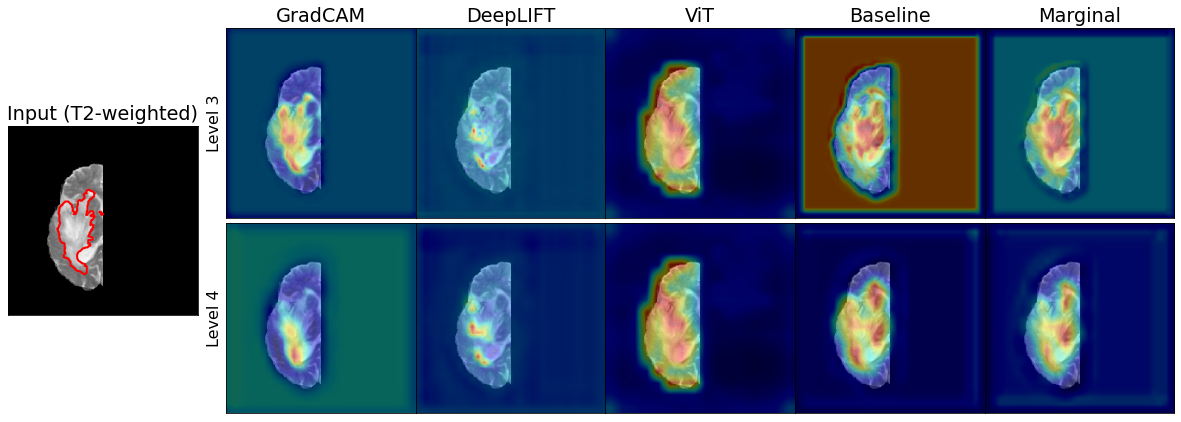

In [51]:
fig = plt.figure(figsize=(3*(len(methods)+1), 2*3*len(samples)))
gs = gridspec.GridSpec(nrows=2*len(samples), 
                       ncols=len(methods)+1+1, 
                       left=0.05, 
                       bottom=0.05, 
                       right=0.95, 
                       top=0.95, 
                       wspace=0.0, 
                       hspace=0.01,
                       width_ratios=[1,0.15, *list([1 for i in methods])])

# Set mri image col
mri_col = []
i = 0
for _ in range(len(samples)):
    ax = plt.subplot(gs[i:i+2, 0])
    mri_col.append(ax)
    i += 2

# Set blank image col
blank_col = []
for i in range(2*len(samples)):
    ax = plt.subplot(gs[i, 1])
    blank_col.append(ax)
    
# Set attributions matrix
matrix = []
for i in range(2*len(samples)):
    row = []
    for j in range(len(methods)):
        ax = plt.subplot(gs[i, j+2])
        row.append(ax)
    matrix.append(row)

# Plot mri images
for mri_ax, sample_idx in zip(mri_col, samples):
    image, label, mask = images_and_masks[sample_idx]
    mri_ax.imshow(image[mri_modality], cmap="gray")
    mri_ax.contour(np.arange(mask.shape[0]), np.arange(mask.shape[1]), mask, 0, linewidths=2, colors=["red"])

# Plot attribution
running_idx = 0
for i in range(0, 2*len(samples), 2):
    idx = samples[running_idx]
    image, label, mask = images_and_masks[idx]
    for j in range(len(methods)):
        attr3 = methods[j][1][idx][0]
        attr3 = cv2.resize(attr3.numpy(), (256, 256), interpolation=cv2.INTER_LINEAR)
        attr4 = methods[j][2][idx][0]
        attr4 = cv2.resize(attr4.numpy(), (256, 256), interpolation=cv2.INTER_LINEAR)
        matrix[i][j].imshow(image[mri_modality], cmap="gray")
        matrix[i][j].imshow(attr3, cmap="jet", alpha=0.4)
        matrix[i+1][j].imshow(image[mri_modality], cmap="gray")
        matrix[i+1][j].imshow(attr4, cmap="jet", alpha=0.4)
    running_idx += 1

# Set titles
mri_col[0].set_title(f"Input (T2-weighted)")
for j, ax in enumerate(matrix[0]):
    ax.set_title(methods[j][0])
    
for i, row in enumerate(matrix):
    if i % 2 == 0:
        row[0].set_ylabel("Level 3", labelpad=0.0)
    else:
        row[0].set_ylabel("Level 4", labelpad=0.0)
        
for ax in mri_col:
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.tick_params(axis='both', which='both', length=0)
    
for ax in blank_col:
    ax.axis("off")
    
for row in matrix:
    for ax in row:
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.tick_params(axis='both', which='both', length=0)